### The script is split into 2 parts. The 1st part is to perform analysis on by country datasets and the 2nd part is to perform final cleaning to reduce the dataset to a smaller subset of countries for modeling and forecasting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

In [2]:
merged_file = pd.read_csv('.\Market_food_prices_w_temp_replaced_final.csv')

Drop columns that are not required

In [3]:
cols = ['locality_id','locality_name','mkt_id','mkt_name','currency_id', 'currency_name', 
        'measurement_id','measurement_unit','price_paid','measurement_const','measurement_unit_type', 
        'mkt_type', 'converted_const', 'mkt_type_id', 'commodity_source', 'converted_unit', 'avg_temp_uncty']
merged_file.drop(cols ,axis=1, inplace=True)
merged_file.to_csv('.\Market_food_prices_w_temp_converted_clean.csv', index=False)

Check for outliers in each variable

In [4]:
sns.set(rc={'figure.figsize':(40,15)})

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60]),
 <a list of 61 Text xticklabel objects>)

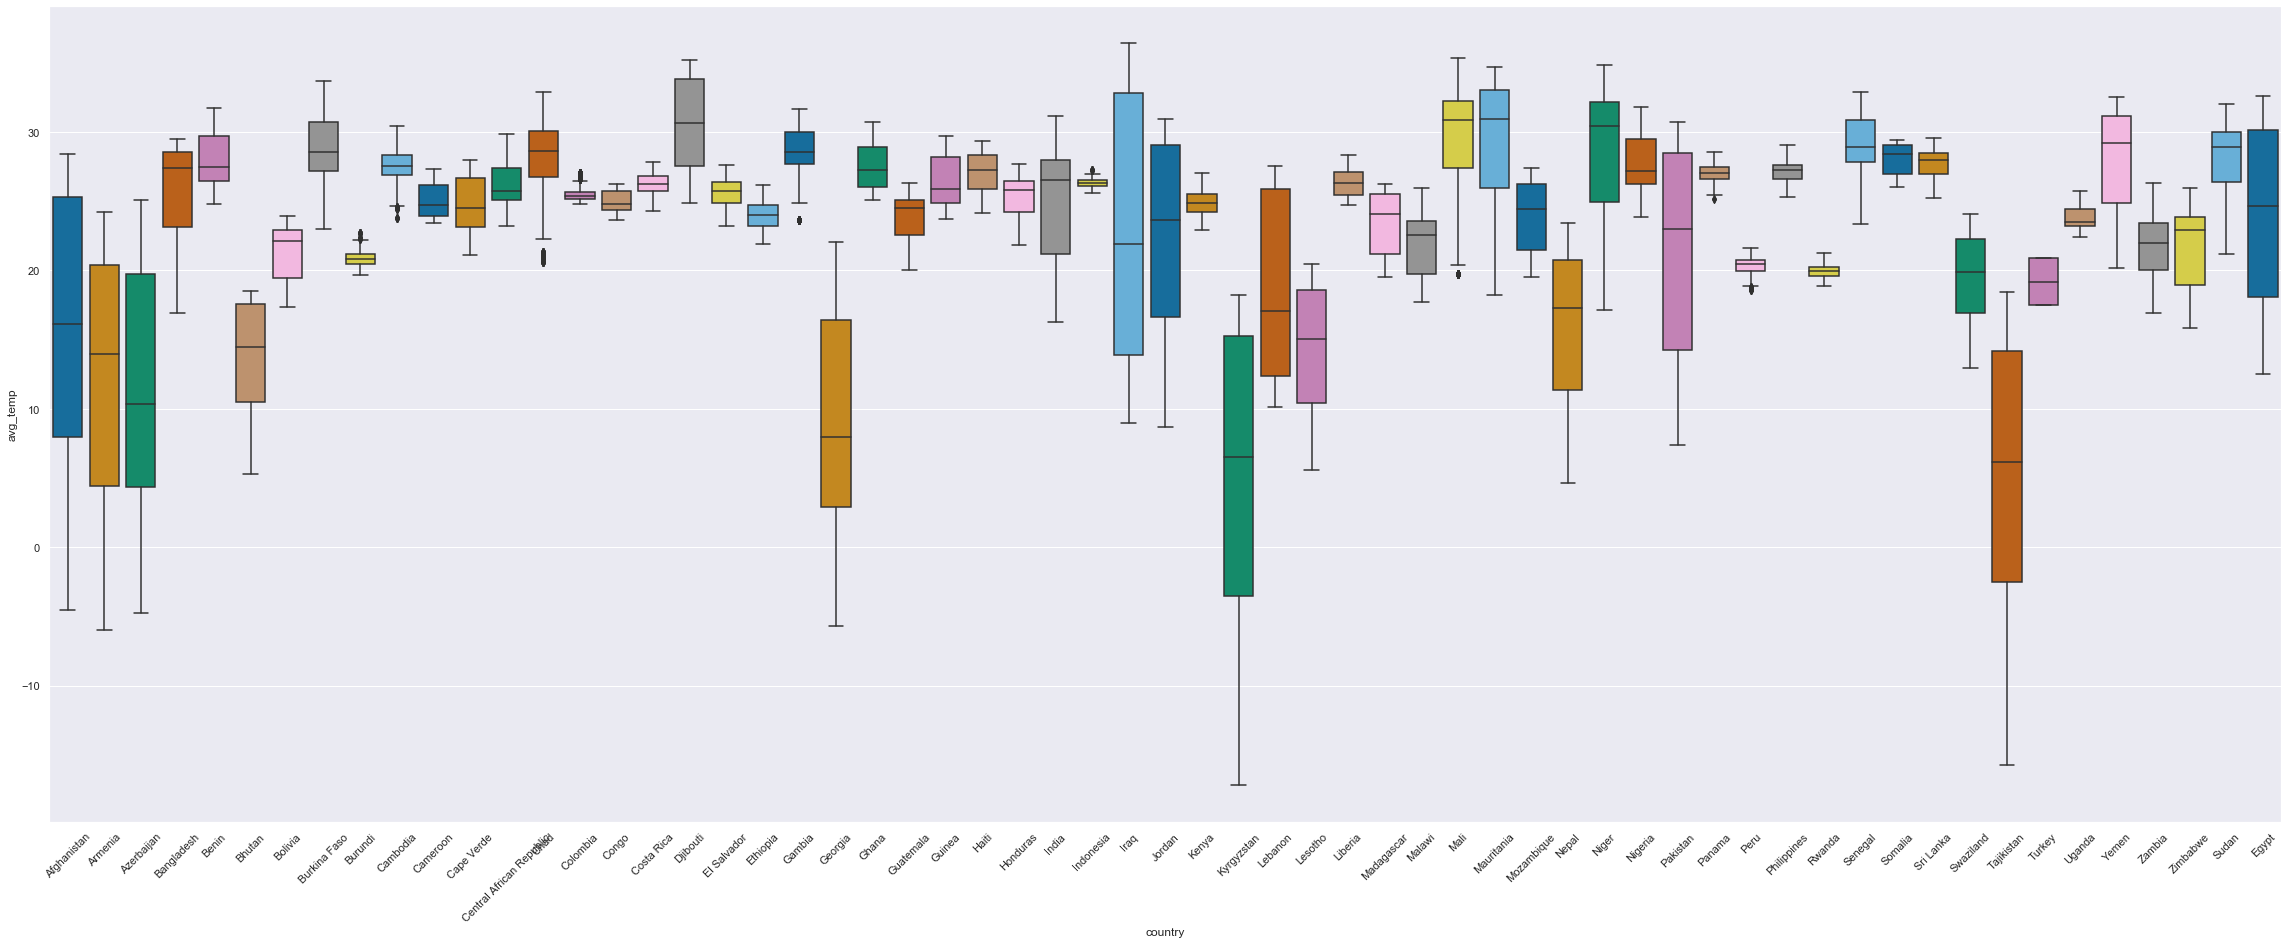

In [5]:
#Avg_temp per country
sns.boxplot(x=merged_file['country'],y=merged_file['avg_temp'],width=0.8, fliersize=5, palette="colorblind")
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60]),
 <a list of 61 Text xticklabel objects>)

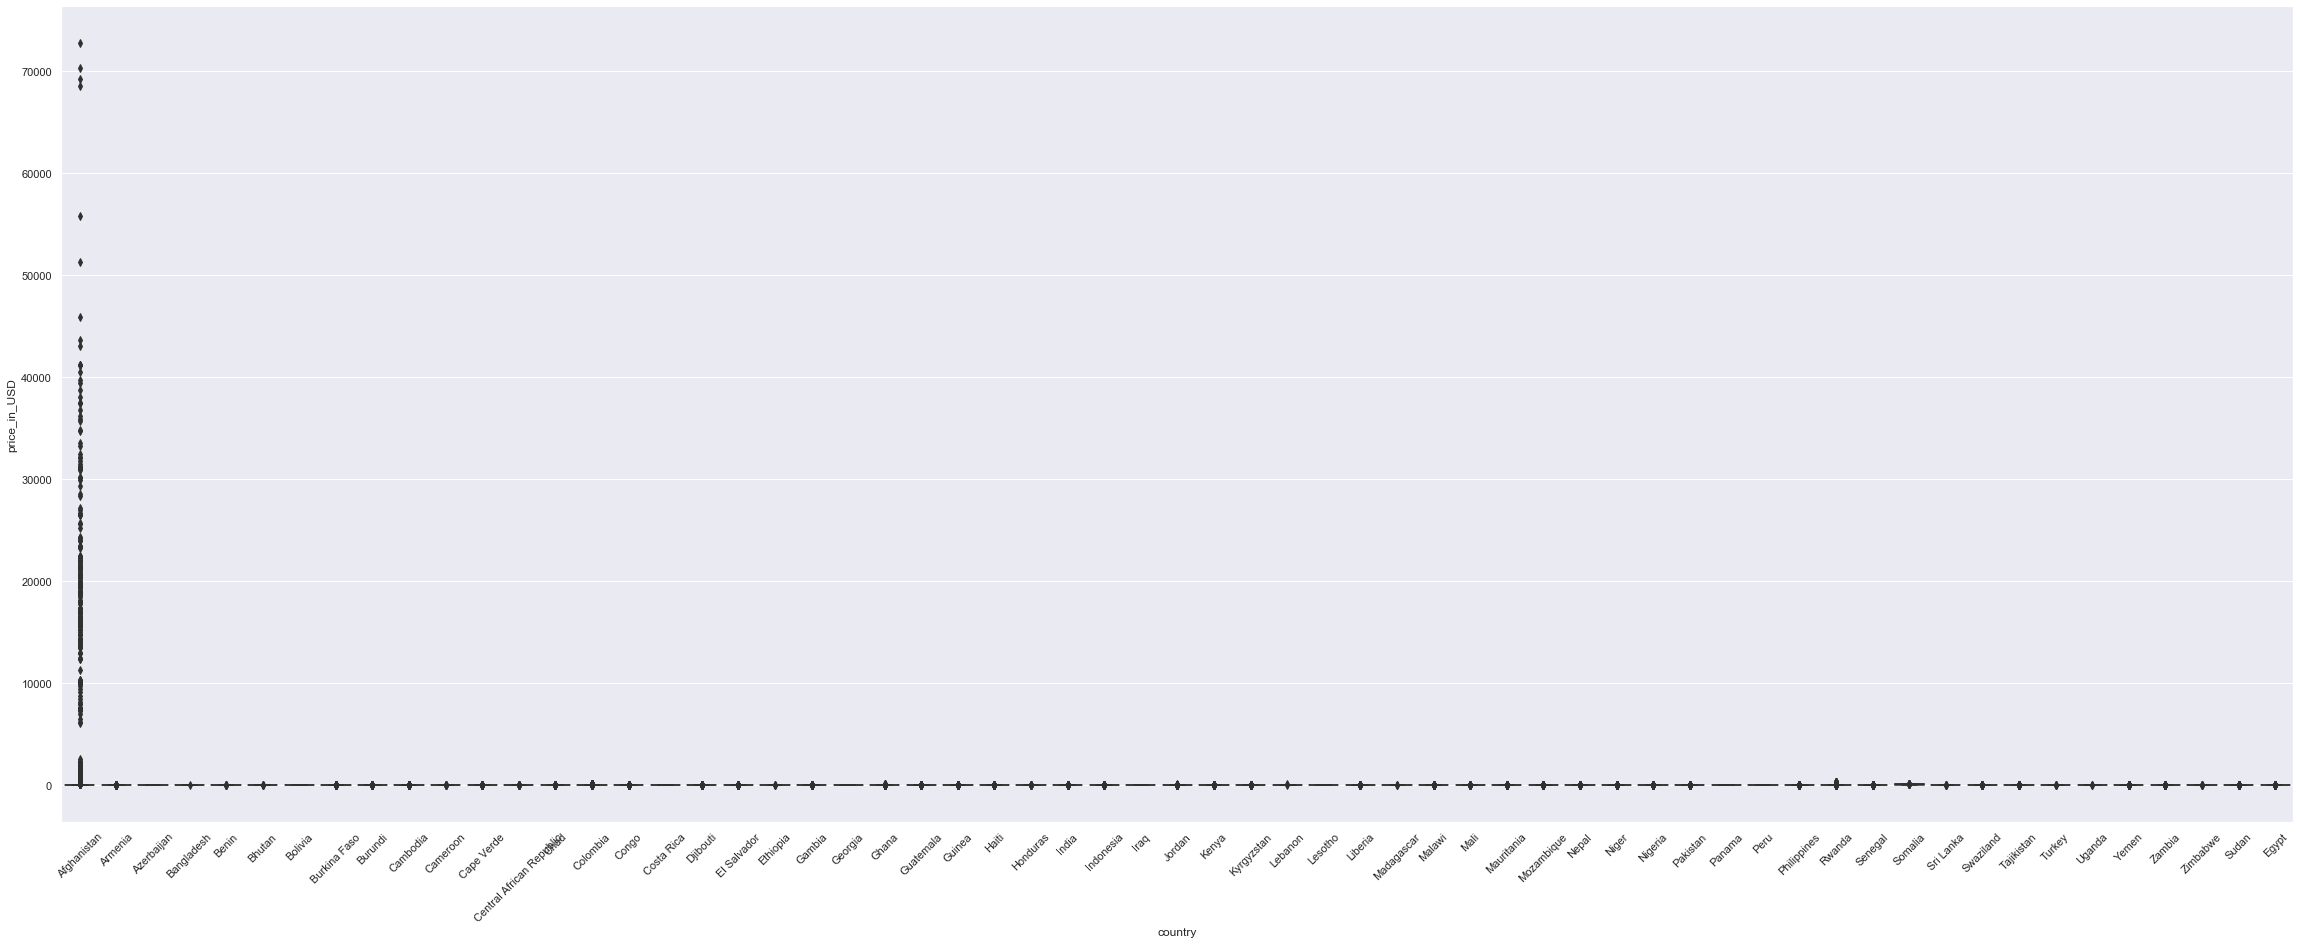

In [6]:
#Price_in_USD per country
sns.boxplot(x=merged_file['country'],y=merged_file['price_in_USD'],width=0.8, fliersize=5, palette="colorblind")
plt.xticks(rotation=45)

In [7]:
sns.set(rc={'figure.figsize':(11,8)})

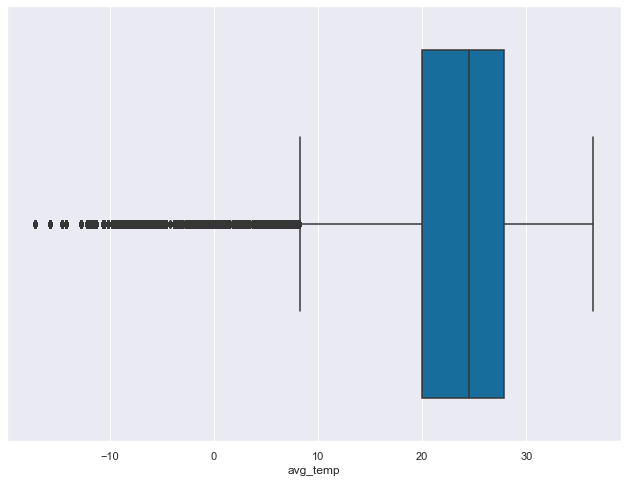

In [8]:
sns.boxplot(x=merged_file['avg_temp'],width=0.8,palette="colorblind")

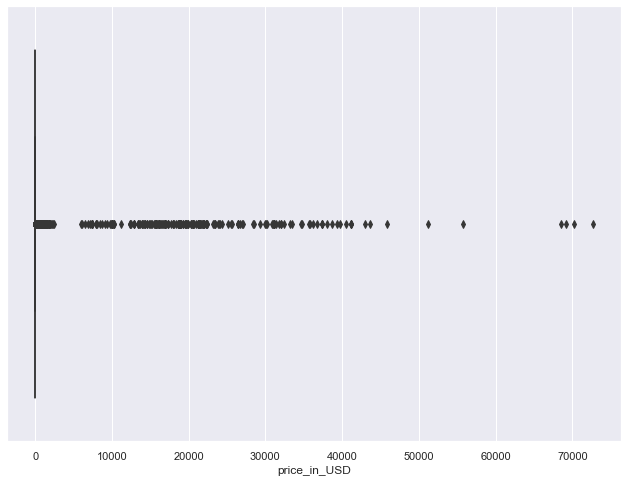

In [9]:
sns.boxplot(x=merged_file['price_in_USD'], width=0.8, palette="colorblind")

In [10]:
Q1 = merged_file.quantile(0.25)
Q3 = merged_file.quantile(0.75)
IQR = Q3 - Q1
print (IQR)

country_id               90.000000
commodity_purchase_id    23.000000
avg_temp                  7.847000
price_in_USD              0.428771
dtype: float64


In [11]:
merged_file.set_index('period', inplace=True)
df_num = merged_file[['avg_temp', 'price_in_USD']]
df_result = (df_num < (Q1 - 1.5 * IQR)) |(df_num > (Q3 + 1.5 * IQR))
df_join = pd.concat([merged_file, df_result], axis=1)
df_join.to_csv(r".\outliers-numeric_cols.csv", index=True, header=True)

Group the data per country based on commodity and date - apply the mean of the prices

In [12]:
merged_file_group = merged_file.groupby(['period', 'country', 'country_id', 
                                         'commodity_purchased','commodity_purchase_id', 
                                         'avg_temp'])['price_in_USD'].mean().reset_index()
merged_file_group.set_index('period', inplace=True)
merged_file_group.to_csv('.\Market_food_prices_w_temp_grouped.csv', index=True)

In [13]:
print("Merged grouped file")
print("="*60)
print(merged_file_group.info())
print("="*60)
print("Shape of the file")
print("="*60)
print(merged_file_group.shape)
print("="*60)
print("Unique values")
print("="*60)
print(merged_file_group.nunique())
print("="*60)
print("Describe the file")
print("="*60)
print(merged_file_group.describe(include='all'))
print("="*60)
print("Check for any null values")
print("="*60)
print(merged_file_group.isnull().sum())

Merged grouped file
<class 'pandas.core.frame.DataFrame'>
Index: 27437 entries, 1992-01-01 to 2013-09-01
Data columns (total 6 columns):
country                  27437 non-null object
country_id               27437 non-null int64
commodity_purchased      27437 non-null object
commodity_purchase_id    27437 non-null int64
avg_temp                 27437 non-null float64
price_in_USD             27437 non-null float64
dtypes: float64(2), int64(2), object(2)
memory usage: 1.5+ MB
None
Shape of the file
(27437, 6)
Unique values
country                     61
country_id                  61
commodity_purchased         70
commodity_purchase_id       70
avg_temp                  4988
price_in_USD             23772
dtype: int64
Describe the file
           country    country_id commodity_purchased  commodity_purchase_id  \
count        27437  27437.000000               27437           27437.000000   
unique          61           NaN                  70                    NaN   
top     Tajikista

### This is the 2nd part of the script

Reduce dataset to selected countries

In [14]:
list = ['Bangladesh','Benin','Burkina Faso','Burundi','Central African Republic','Chad','Costa Rica','El Salvador','Guatemala','India','Kenya','Mali','Mozambique','Nepal','Niger','Peru','Senegal','Tajikistan']

reduced_group = pd.DataFrame()
reduced_group_revised = pd.DataFrame()

for i in range(len(list)):
    df = pd.DataFrame()
    df = merged_file_group[merged_file_group['country'] == list[i]]
    reduced_group = reduced_group.append(df, ignore_index = False)  
   

Remove initial records for Chad, Benin, Costa Rica 

In [15]:
merged_file_group = merged_file_group.reset_index()
indexNames = merged_file_group[(merged_file_group['country'] == 'Benin') & (merged_file_group['period'] == "2002-01-01")
                          |(merged_file_group['country'] == 'Chad') & (merged_file_group['period'] <= "2003-12-01") 
                          |(merged_file_group['country'] == 'Costa Rica') & (merged_file_group['period'] <= "2007-12-01")].index
merged_file_group.drop(indexNames, axis=0, inplace=True)
merged_file_group = merged_file_group.set_index('period')
# merged_file_group.to_csv(r'.\check.csv', index=True)

Impute missing commodities per country using the mean price per commodity

In [16]:
for i in range(len(list)):
    df = merged_file_group[merged_file_group['country'] == list[i]]
    df = df.reset_index()
    df_revised = pd.pivot_table(df, values='price_in_USD', index=['period'], columns='commodity_purchased', aggfunc = sum).reset_index()
    df_revised = df_revised.set_index('period')
    df_revised = df_revised.apply(lambda x: x.fillna(x.mean()),axis=0)
    sf = df_revised.stack().reset_index().rename(columns={0:'price_in_USD'})
    df_revised = pd.DataFrame(sf)
    df_revised['country'] = list[i]
    reduced_group_revised = reduced_group_revised.append(df_revised, ignore_index=False)

orig = merged_file_group.reset_index()
orig = orig.drop(["commodity_purchase_id", "commodity_purchased", "price_in_USD"], axis=1)
orig = orig.drop_duplicates()
reduced_group_revised = reduced_group_revised.drop_duplicates()

df_inner = pd.merge(reduced_group_revised, orig, on=['period', 'country'], how='inner')

commodity_dict = dict(zip(merged_file_group.commodity_purchased,merged_file_group.commodity_purchase_id))

df_inner ['commodity_purchase_id'] = df_inner['commodity_purchased'].map(commodity_dict)
new_df = df_inner.copy().set_index('period')
df_inner = df_inner[['period', 'country', 'country_id', 'commodity_purchased', 'commodity_purchase_id', 'avg_temp', 'price_in_USD']]
df_inner = df_inner.set_index('period').to_csv(r'.\Market_food_prices_w_temp_reduced.csv', index=True)

Create a country data dictionary

In [17]:
country_dict = dict(zip(reduced_group.country_id,reduced_group.country))
print(country_dict)

{23: 'Bangladesh', 29: 'Benin', 42: 'Burkina Faso', 43: 'Burundi', 49: 'Central African Republic', 50: 'Chad', 61: 'Costa Rica', 75: 'El Salvador', 103: 'Guatemala', 115: 'India', 133: 'Kenya', 155: 'Mali', 170: 'Mozambique', 175: 'Nepal', 181: 'Niger', 195: 'Peru', 217: 'Senegal', 239: 'Tajikistan'}


Separate the 18 countries to individual dataframes and output to csv

In [18]:
for key, value in country_dict.items():
    country_dict[key] = new_df[:][new_df.country_id == key]
    country_dict[key].to_csv(r".\countries\country_df_" + str(value) + ".csv", index=True, header=True)
    